**Short text classification (Customer Reviews)**  

In this assignment our aim is to predict a rating based on a given review. The reviews are text reviews, and the training dataset has been made available in this directory

Pretrained BERT_base is used in this Assignment.
While trainig, all parameters of bert were kept freezed. 

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
f = open("/content/drive/MyDrive/dlnlp-3/digital_music_5.x.train.txt")
data = []
for line in f:
  data.append(line)
f.close()
print(len(data))

f = open("/content/drive/MyDrive/dlnlp-3/digital_music_5.y.train.txt")
labels = []
for line in f:
  labels.append(float(line.split("\n")[0]))
f.close()
print(len(labels))
print(labels[:10])

58235
58235
[4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0]


In [ ]:
for i in range(len(labels)):
  labels[i]-=1

print(labels[:10])

[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0]


In [ ]:
test_size = 0.2
from sklearn.model_selection import train_test_split
corpus_train, corpus_dev, labels_train, labels_dev = train_test_split(data,labels,test_size=test_size)
print(len(corpus_train))
print(len(corpus_dev))

46588
11647


In [ ]:
##### basic preprocessing for text

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):

    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = doc.replace('"',"")

    # tokenize document
    tokens = wpt.tokenize(doc)

    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # re-create document from filtered tokens
    return " ".join(filtered_tokens)

In [ ]:
pro_corpus_train = [] 
for doc in corpus_train:
  pro_corpus_train.append(normalize_document(doc))

pro_corpus_dev = [] 
for doc in corpus_dev:
  pro_corpus_dev.append(normalize_document(doc))


In [ ]:
print(len(pro_corpus_train))
print(len(pro_corpus_dev))

46588
11647


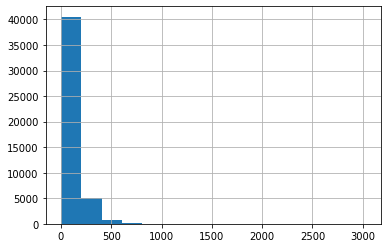

In [ ]:
##### analyzing average length of the documents
seq_len = [len(i.split()) for i in pro_corpus_train]

pd.Series(seq_len).hist(bins = 15)

In [ ]:
!pip install transformers

In [ ]:
import transformers
from transformers import AutoModel, BertTokenizer

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
c=0
for param in bert.parameters():
  c+=1
print(c)

In [ ]:

# freeze all the parameters
for param in bert.parameters():
  param.requires_grad = False



In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    pro_corpus_train,
    padding = True,
    max_length = 250,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_dev = tokenizer.batch_encode_plus(
    pro_corpus_dev,
    padding = True,
    max_length = 250,
    truncation=True
)

In [ ]:
import torch
import torch.nn as nn


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'],dtype=torch.int64)
train_mask = torch.tensor(tokens_train['attention_mask'],dtype=torch.int64)
train_y = torch.tensor(labels_train,dtype=torch.int64)

dev_seq = torch.tensor(tokens_dev['input_ids'],dtype=torch.int64)
dev_mask = torch.tensor(tokens_dev['attention_mask'],dtype=torch.int64)
dev_y = torch.tensor(labels_dev,dtype=torch.int64)

In [ ]:
print(dev_seq.shape)
print(dev_mask.shape)

torch.Size([11647, 250])
torch.Size([11647, 250])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)

# sampler for sampling the data during training
dev_sampler = SequentialSampler(dev_data)

# dataLoader for validation set
dev_dataloader = DataLoader(dev_data, sampler = dev_sampler, batch_size=batch_size)

In [ ]:
print(labels_train[:20])

[3.0, 4.0, 3.0, 4.0, 1.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 2.0, 4.0, 4.0, 3.0, 4.0, 3.0]


In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      #self.lstm = nn.LSTM(input_size=768, hidden_size=256,batch_first=True)
      self.fc2 = nn.Linear(512,64)
      
      # dense layer 2 (Output layer)
      self.out = nn.Linear(64,5)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      
      x = self.relu(self.fc1(cls_hs))
      x = self.relu(self.fc2(x))

      #x = self.dropout(x)

      # output layer
      x = self.out(x) 
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
model = BERT_Arch(bert)
device = torch.device("cuda")
# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW
from babel.dates import format_time
import time

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 5e-4)
cross_entropy = nn.CrossEntropyLoss()
epochs = 10

In [ ]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  '''
  # empty list to save model predictions
  total_preds=[]'''
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # push the batch to gpu
    #batch = [r.to(device) for r in batch]
    
 
    sent_id, mask, labels = batch[0].to(device),batch[1].to(device),batch[2].to(device)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # backward pass to calculate the gradients
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # add on to the total loss
    loss_item = loss.item()

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
      print("loss",loss_item)

    total_loss = total_loss + loss_item

    '''
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)'''

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  #total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss

In [ ]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()
  t0 = time.time()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  count=0

  # iterate over batches
  for step,batch in enumerate(dev_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dev_dataloader)))

    # push the batch to gpu
    #batch = [t.to(device) for t in batch]
    

    sent_id, mask, labels = batch[0].to(device),batch[1].to(device),batch[2].to(device)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

      true_class = np.argmax(preds,axis=1)
      for myvar in range(len(labels)):
        if labels[myvar]== true_class[myvar]:
          count+=1

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(dev_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  print("Validation accuracy",count/(len(dev_dataloader)*batch_size))

  return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    728.
loss 1.2580506801605225
  Batch   100  of    728.
loss 1.2362490892410278
  Batch   150  of    728.
loss 1.1422157287597656
  Batch   200  of    728.
loss 1.307981014251709
  Batch   250  of    728.
loss 1.0785303115844727
  Batch   300  of    728.
loss 1.1292082071304321
  Batch   350  of    728.
loss 1.2482842206954956
  Batch   400  of    728.
loss 1.1211516857147217
  Batch   450  of    728.
loss 1.1445361375808716
  Batch   500  of    728.
loss 1.1100049018859863
  Batch   550  of    728.
loss 1.2164679765701294
  Batch   600  of    728.
loss 1.0990663766860962
  Batch   650  of    728.
loss 1.15267014503479
  Batch   700  of    728.
loss 1.1828923225402832

Evaluating...
  Batch    50  of    182.
  Batch   100  of    182.
  Batch   150  of    182.
Validation accuracy 0.5554601648351648

Training Loss: 1.158
Validation Loss: 1.093

 Epoch 2 / 10
  Batch    50  of    728.
loss 1.2087725400924683
  Batch   100  of    728.
loss 1.2990130186080

KeyboardInterrupt: ignored

In [ ]:
!pip install "tensorflow>=1.7.0"
!pip install tensorflow-hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:

tf.compat.v1.disable_eager_execution()
url = "https://tfhub.dev/google/elmo/3"
embed =hub.Module(url)

In [ ]:
list_train = [pro_corpus_train[i:i+10] for i in range(0,pro_corpus_train.shape[0],10)]

In [ ]:
print(len(list_train[0]))

In [ ]:
def elmo_vectors(x):
  embeddings = embed(x, signature="default", as_dict=True)["elmo"]

  with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(tf.compat.v1.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [ ]:
elmo_train = [elmo_vectors(x) for x in list_train]